In [57]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [58]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Melihat statistik dasar
print(df.describe())
print(df.info())

       Soil Moisture  Temperature  Air Humidity    Pump Data
count    3000.000000  3000.000000   3000.000000  3000.000000
mean      662.419754    28.443043     59.387209     0.523000
std       187.936297     6.018565     12.428161     0.499554
min       314.511016    18.002132     38.000201     0.000000
25%       501.362575    23.320750     48.661993     0.000000
50%       666.578554    28.361854     58.975423     1.000000
75%       821.867423    33.595989     70.138397     1.000000
max       984.828010    38.992770     81.267407     1.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Soil Moisture  3000 non-null   float64
 1   Temperature    3000 non-null   float64
 2   Air Humidity   3000 non-null   float64
 3   Pump Data      3000 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 93.9 KB
None


In [59]:
# Hitung jumlah masing-masing nilai di kolom Pump_Data
pump_counts = df['Pump Data'].value_counts()

# Cetak hasil
print("Jumlah Pump_Data = 1:", pump_counts.get(1, 0))
print("Jumlah Pump_Data = 0:", pump_counts.get(0, 0))

Jumlah Pump_Data = 1: 1569
Jumlah Pump_Data = 0: 1431


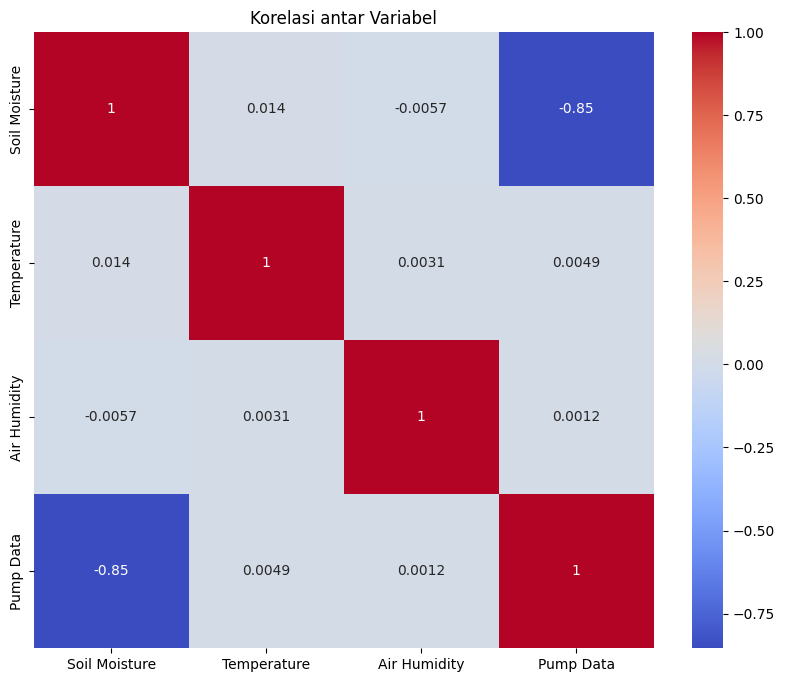

In [60]:
# Memeriksa korelasi antar variabel
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Korelasi antar Variabel')
plt.show()

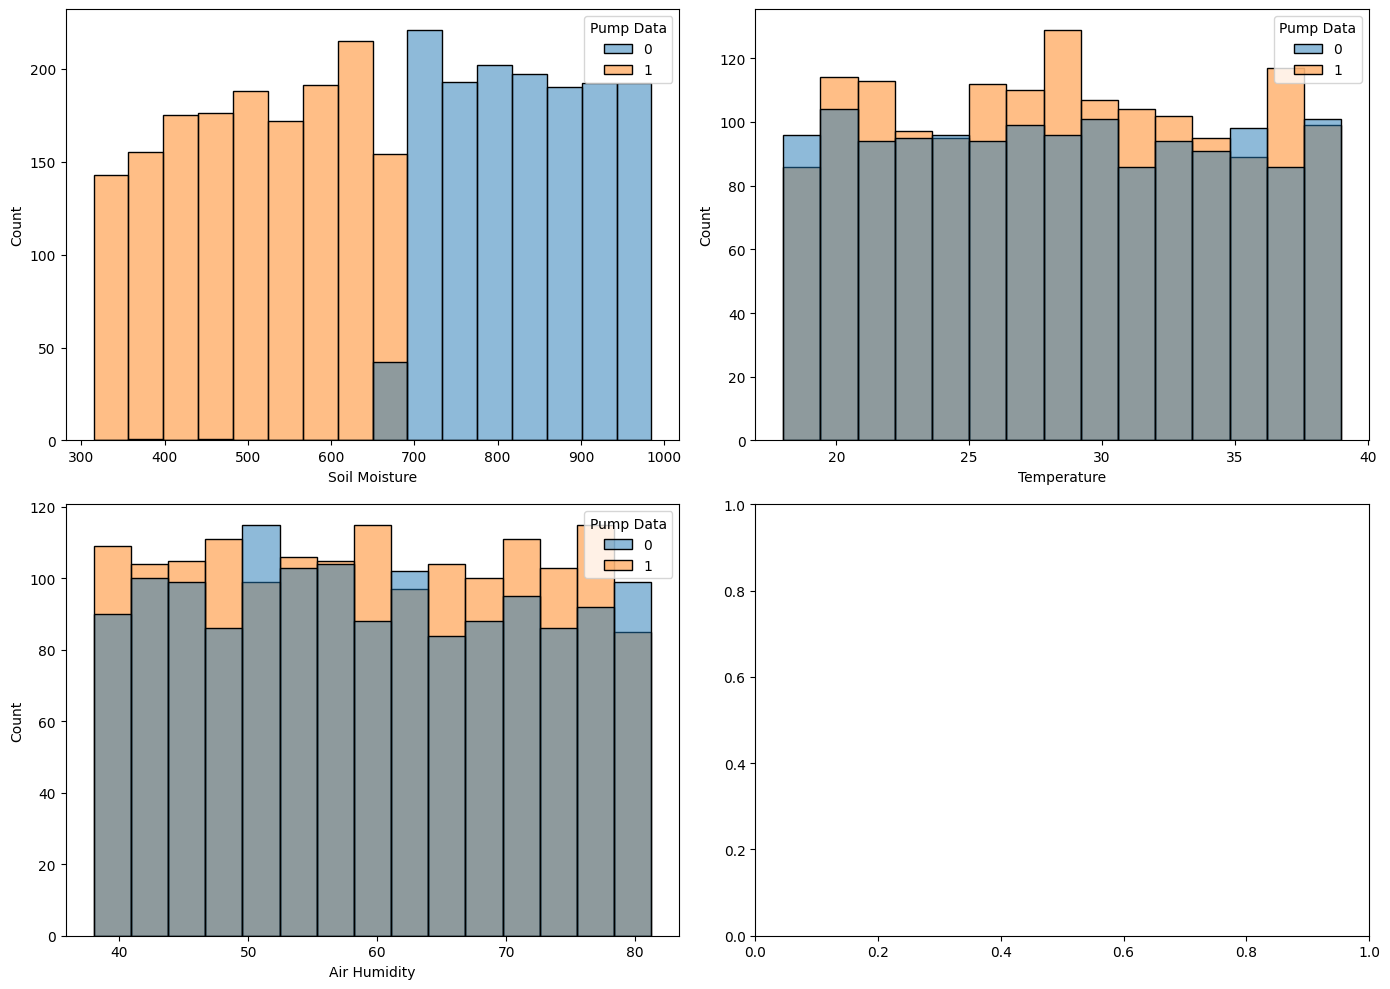

In [61]:
# Visualisasi distribusi data
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(data=df, x='Soil Moisture', hue='Pump Data', ax=axes[0, 0])
sns.histplot(data=df, x='Temperature', hue='Pump Data', ax=axes[0, 1])
sns.histplot(data=df, x='Air Humidity', hue='Pump Data', ax=axes[1, 0])
plt.tight_layout()
plt.show()


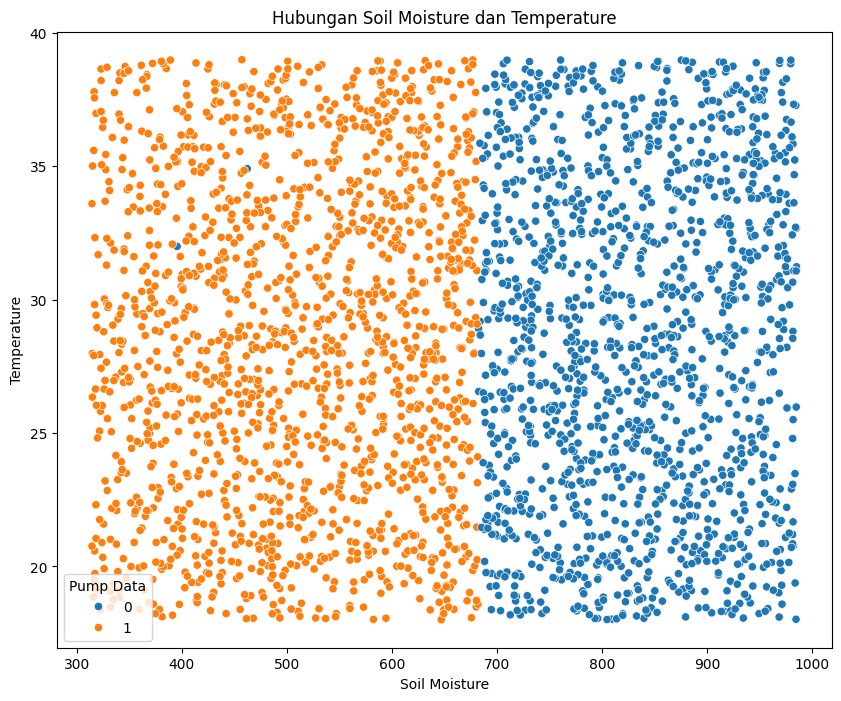

In [62]:
# Visualisasi scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='Soil Moisture', y='Temperature', hue='Pump Data')
plt.title('Hubungan Soil Moisture dan Temperature')
plt.show()

In [63]:
# Pisahkan fitur dan target
X = df[['Soil Moisture', 'Temperature', 'Air Humidity']]
y = df['Pump Data']

In [64]:
# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Normalisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
def build_irrigation_model(input_shape):
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Dense(16, activation='relu', input_shape=(input_shape,)),

        # Hidden layers
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(12, activation='relu'),

        # Output layer - binary classification (siram/tidak)
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

In [67]:
# Buat model
input_dim = X_train_scaled.shape[1]
irrigation_model = build_irrigation_model(input_dim)

# Ringkasan model
irrigation_model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 785 (3.07 KB)

 Trainable params: 785 (3.07 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Tambahkan callbacks untuk early stopping dan model checkpoint
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_irrigation_model.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

In [69]:
# Latih model
history = irrigation_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=4,  # Kecil karena dataset kecil
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.8568 - loss: 0.4255 - precision_3: 0.8417 - recall_3: 0.9106 - val_accuracy: 0.9917 - val_loss: 0.0507 - val_precision_3: 0.9958 - val_recall_3: 0.9874
Epoch 2/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - accuracy: 0.9864 - loss: 0.0641 - precision_3: 0.9914 - recall_3: 0.9821 - val_accuracy: 0.9917 - val_loss: 0.0272 - val_precision_3: 0.9916 - val_recall_3: 0.9916
Epoch 3/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.9899 - loss: 0.0283 - precision_3: 0.9903 - recall_3: 0.9906 - val_accuracy: 0.9896 - val_loss: 0.0227 - val_precision_3: 0.9835 - val_recall_3: 0.9958
Epoch 4/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.9921 - loss: 0.0362 - precision_3: 0.9922 - recall_3: 0.9933 - val_accuracy: 0.9979 - val_loss: 0.0154 - val_precision_3: 1.0000 - val_recall_3: 0.9958
Epoch 5/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 464us/step - accuracy: 0.9969 - loss: 0.0180 - precision_3: 0.9969 - rec

In [70]:
# Evaluasi model
test_results = irrigation_model.evaluate(X_test_scaled, y_test, verbose=1)
print(f"Test Loss: {test_results[0]}")
print(f"Test Accuracy: {test_results[1]}")
print(f"Test Precision: {test_results[2]}")
print(f"Test Recall: {test_results[3]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 0.9969 - loss: 0.0227 - precision_3: 0.9957 - recall_3: 0.9982   
Test Loss: 0.027667585760354996
Test Accuracy: 0.9950000047683716
Test Precision: 0.9933993220329285
Test Recall: 0.996688723564148


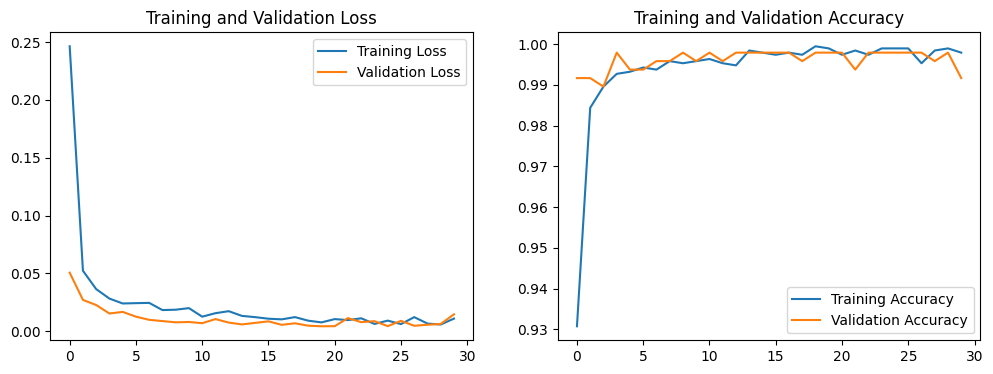

In [71]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [72]:
import requests
import json

def get_weather_forecast(api_key, location):
    """
    Mendapatkan prediksi cuaca dari Weather API
    """
    # Contoh URL untuk OpenWeatherMap API
    url = f"https://api.openweathermap.org/data/2.5/forecast?q={location}&appid={api_key}&units=metric"

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()

        # Ekstrak informasi cuaca yang relevan
        forecast = data['list'][0]  # Prediksi cuaca terdekat

        # Periksa apakah akan hujan
        will_rain = False
        rain_amount = 0.0

        # Cek kondisi cuaca
        weather_condition = forecast['weather'][0]['main'].lower()
        if 'rain' in weather_condition:
            will_rain = True
            # Jika ada informasi jumlah hujan
            if 'rain' in forecast and '3h' in forecast['rain']:
                rain_amount = forecast['rain']['3h']  # curah hujan dalam 3 jam (mm)

        # Suhu dari API
        temperature = forecast['main']['temp']
        humidity = forecast['main']['humidity']

        return {
            'rain_forecast': 'Yes' if will_rain else 'No',
            'rain_amount': rain_amount,
            'api_temperature': temperature,
            'api_humidity': humidity
        }
    else:
        # Jika error, kembalikan nilai default
        return {
            'rain_forecast': 'No',
            'rain_amount': 0.0,
            'api_temperature': None,
            'api_humidity': None
        }

In [73]:
res = get_weather_forecast("1abea4adf5a8e3217023e324e339b83e", "Malang")
print(res)

{'rain_forecast': 'Yes', 'rain_amount': 0.38, 'api_temperature': 27.68, 'api_humidity': 94}


In [74]:
import pickle
# 6.1. Simpan model
irrigation_model.save('best_irrigation_model.keras')

# 6.2. Simpan scaler (SETELAH model dilatih)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [75]:
import numpy as np
import requests
import tensorflow as tf
import joblib

# === 1. Input Manual dari User ===
def input_sensor_manual():
    """Input manual dari user untuk testing"""

    print("\n=== INPUT DATA SENSOR ===")
    soil_moisture = float(input("Masukkan kelembaban tanah (0 - 1023): "))
    temperature = float(input("Masukkan suhu udara sensor (°C): "))
    humidity = float(input("Masukkan kelembaban udara sensor (%): "))
    return {
            "soil_moisture": soil_moisture,
            "temperature": temperature,
            "humidity": humidity
            }

# === 2. Ambil Data Cuaca dari Weather API ===
def get_weather_forecast(api_key, location="Malang"):
    """
    Mendapatkan prediksi cuaca dari Weather API
    """
    url = f"https://api.openweathermap.org/data/2.5/forecast?q=Malang,&appid={api_key}&units=metric"

    try:
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            forecast = data['list'][0]  # prediksi terdekat

            will_rain = False
            rain_amount = 0.0

            if 'weather' in forecast and forecast['weather']:
                weather_condition = forecast['weather'][0]['main'].lower()
                if 'rain' in weather_condition:
                    will_rain = True
                    if 'rain' in forecast and '3h' in forecast['rain']:
                        rain_amount = forecast['rain']['3h']

            return {
                'rain_forecast': 1 if will_rain else 0,  # Convert to numeric
                'rain_amount': rain_amount,
                'api_temperature': forecast['main']['temp'],
                'api_humidity': forecast['main']['humidity']
            }
    except Exception as e:
        print(f"Error fetching weather data: {e}")

    # Return default values if API fails
    return {
        'rain_forecast': 0,
        'rain_amount': 0.0,
        'api_temperature': 25.0,  # Default temperature
        'api_humidity': 60.0       # Default humidity
    }

def calculate_weather_influence(weather_data, sensor_data):
    """
    Menghitung faktor pengaruh cuaca terhadap keputusan penyiraman
    Return: nilai antara -1 (sangat mengurangi kebutuhan siram) hingga +1 (sangat menambah kebutuhan siram)
    """
    influence = 0.0

    # Faktor hujan (paling berpengaruh)
    if weather_data['rain_forecast'] == 1:
        rain_influence = min(weather_data['rain_amount'] / 10.0, 1.0)  # Normalisasi 0-1
        influence -= rain_influence * 0.6  # Mengurangi kebutuhan siram hingga -0.6

    # Faktor perbedaan suhu sensor vs weather API
    if weather_data['api_temperature'] is not None:
        temp_diff = weather_data['api_temperature'] - sensor_data['temperature']
        # Jika suhu API lebih tinggi, menambah kebutuhan siram
        temp_influence = np.tanh(temp_diff / 10.0) * 0.2  # Normalisasi dengan tanh
        influence += temp_influence

    # Faktor perbedaan kelembaban
    if weather_data['api_humidity'] is not None:
        humidity_diff = weather_data['api_humidity'] - sensor_data['humidity']
        # Jika kelembaban API lebih rendah, menambah kebutuhan siram
        humidity_influence = -np.tanh(humidity_diff / 20.0) * 0.2
        influence += humidity_influence

    # Batasi influence antara -1 dan +1
    return np.clip(influence, -1.0, 1.0)

def adjust_prediction_with_weather(base_prob, weather_factor):
    """
    Menyesuaikan probabilitas prediksi model dengan faktor cuaca
    """
    # Gunakan sigmoid adjustment untuk mempertahankan range 0-1
    adjustment = weather_factor * 0.3  # Maksimal adjustment 30%
    adjusted_logit = np.log(base_prob / (1 - base_prob + 1e-8)) + adjustment
    adjusted_prob = 1 / (1 + np.exp(-adjusted_logit))

    return np.clip(adjusted_prob, 0.01, 0.99)  # Hindari ekstrem 0 atau 1

def generate_decision_reason(base_prob, weather_factor, final_prob, should_water, weather_data, sensor_data):
    """
    Generate penjelasan keputusan yang informatif
    """
    base_decision = "siram" if base_prob >= 0.5 else "tidak siram"

    reason_parts = []
    reason_parts.append(f"Model dasar merekomendasikan {base_decision} (confidence: {base_prob:.2f})")

    if abs(weather_factor) > 0.1:  # Jika ada pengaruh cuaca yang signifikan
        if weather_factor > 0:
            reason_parts.append(f"Kondisi cuaca menambah kebutuhan penyiraman (+{weather_factor:.2f})")
        else:
            reason_parts.append(f"Kondisi cuaca mengurangi kebutuhan penyiraman ({weather_factor:.2f})")

        # Detail faktor cuaca
        if weather_data['rain_forecast'] == 1:
            reason_parts.append(f"Prediksi hujan {weather_data['rain_amount']:.1f}mm")

        if weather_data['api_temperature'] and weather_data['api_temperature'] != sensor_data['temperature']:
            temp_diff = weather_data['api_temperature'] - sensor_data['temperature']
            reason_parts.append(f"Perbedaan suhu sensor vs cuaca: {temp_diff:+.1f}°C")

    final_decision = "SIRAM" if should_water else "TIDAK SIRAM"
    reason_parts.append(f"Keputusan final: {final_decision} (confidence: {final_prob:.2f})")

    return " | ".join(reason_parts)

def make_irrigation_decision_enhanced(sensor_data, weather_data, model, scaler):
    """
    Keputusan penyiraman berdasarkan model ML dengan integrasi weather API
    Menggunakan weighted decision dari model prediksi dan faktor cuaca
    """
    # Persiapkan fitur untuk model asli (3 fitur)
    sensor_features = pd.DataFrame({
        'Soil Moisture': [sensor_data['soil_moisture']],
        'Temperature': [sensor_data['temperature']],
        'Air Humidity': [sensor_data['humidity']]
    })

    # Normalisasi menggunakan scaler yang ada
    sensor_features_scaled = scaler.transform(sensor_features)

    # Prediksi dasar dari model
    base_prediction_prob = model.predict(sensor_features_scaled, verbose=0)[0][0]

    # Faktor modifikasi berdasarkan cuaca (menggunakan logika yang lebih soft)
    weather_factor = calculate_weather_influence(weather_data, sensor_data)

    # Kombinasi prediksi model dengan faktor cuaca
    final_prediction_prob = adjust_prediction_with_weather(base_prediction_prob, weather_factor)

    # Keputusan final
    should_water = bool(final_prediction_prob >= 0.5)

    # Generate explanation
    confidence_level = float(final_prediction_prob)
    reason = generate_decision_reason(base_prediction_prob, weather_factor, confidence_level, should_water, weather_data, sensor_data)

    return {
        'should_water': should_water,
        'confidence': confidence_level,
        'base_model_confidence': float(base_prediction_prob),
        'weather_adjustment': weather_factor,
        'reason': reason,
        'soil_moisture': float(sensor_data['soil_moisture']),
        'temperature': float(sensor_data['temperature']),
        'humidity': float(sensor_data['humidity']),
        'rain_forecast': 'Yes' if weather_data['rain_forecast'] == 1 else 'No',
        'rain_amount': weather_data['rain_amount'],
        'api_temperature': weather_data['api_temperature'],
        'api_humidity': weather_data['api_humidity']
    }

def main_with_user_input():
    """
    Fungsi utama dengan input dari user
    """
    API_KEY = "1abea4adf5a8e3217023e324e339b83e"

    print("=== SISTEM IRIGASI CERDAS ===")
    sensor_data = input_sensor_manual()

    print("\n=== Mengambil data cuaca... ===")
    weather_data = get_weather_forecast(API_KEY)

    try:
        # Load model dan scaler
        print("=== Loading model... ===")
        model = tf.keras.models.load_model("best_irrigation_model.keras")

        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        import pickle
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)

        # Buat prediksi
        result = make_irrigation_decision_enhanced(sensor_data, weather_data, model, scaler)

        print("\n" + "="*50)
        print("           HASIL ANALISIS SISTEM")
        print("="*50)
        print(f"📊 Data Sensor:")
        print(f"   • Kelembaban Tanah    : {result['soil_moisture']}")
        print(f"   • Suhu Sensor         : {result['temperature']} °C")
        print(f"   • Kelembaban Sensor   : {result['humidity']} %")

        print(f"\n🌤️  Data Cuaca:")
        print(f"   • Prediksi Hujan      : {result['rain_forecast']}")
        if result['rain_amount'] > 0:
            print(f"   • Curah Hujan         : {result['rain_amount']} mm")
        print(f"   • Suhu Cuaca          : {result['api_temperature']} °C")
        print(f"   • Kelembaban Cuaca    : {result['api_humidity']} %")

        print(f"\n🤖 Analisis Model:")
        print(f"   • Confidence Model    : {result['base_model_confidence']:.1%}")
        print(f"   • Pengaruh Cuaca      : {result['weather_adjustment']:+.3f}")
        print(f"   • Confidence Final    : {result['confidence']:.1%}")

        print(f"\n🎯 KEPUTUSAN FINAL:")
        decision_icon = "🚿" if result['should_water'] else "⏸️"
        decision_text = "SIRAM TANAMAN" if result['should_water'] else "TIDAK PERLU SIRAM"
        print(f"   {decision_icon} {decision_text}")

        print(f"\n💡 Penjelasan:")
        print(f"   {result['reason']}")
        print("="*50)

    except FileNotFoundError as e:
        print(f"\n❌ File model tidak ditemukan: {e}")
        print("Pastikan file berikut ada di direktori yang sama:")
        print("- best_irrigation_model.keras")
        print("- scaler.pkl")
    except Exception as e:
        print(f"\n❌ Error: {e}")

def menu_utama():
    """
    Menu utama untuk memilih mode operasi
    """
    while True:
        print("\n" + "="*50)
        print("      SISTEM IRIGASI CERDAS")
        print("="*50)
        print("1. Input Manual (Masukkan data sensor sendiri)")
        print("2. Keluar")
        print("="*50)

        try:
            pilihan = input("Pilih mode (1/2): ").strip()

            if pilihan == '1':
                main_with_user_input()
            elif pilihan == '2':
                print("Keluar dari sistem. Terima kasih!")
                break
            else:
                print("Pilihan tidak valid. Silakan pilih 1, 2, atau 3.")

        except KeyboardInterrupt:
            print("\n\nProgram dihentikan oleh user.")
            break
        except Exception as e:
            print(f"Error: {e}")

if __name__ == "__main__":
    # Gunakan menu utama untuk memberikan pilihan kepada user
    menu_utama()


      SISTEM IRIGASI CERDAS
1. Input Manual (Masukkan data sensor sendiri)
2. Keluar
Keluar dari sistem. Terima kasih!
